In [25]:
import numpy as np
import pandas as pd
from typing import Tuple, List
np.random.seed(42)


# BMI Prediction

The premise of this task, to my understanding, is to build a model to predict quote category for the applicants using a machine learning model trained from a dataset, whose labels are to be constructed using the set of given rules.

## Dissecting the problem

The business rules define the "perfect" solution to the problem, obviously in the real life we won't have this oracle knowledge about how to solve a complex problem -- if we have access to the said oracle, the problem would be already solved, therefore the "perfect" solution is the "truth" label we (or our machine learning model) are supposed to learn from. 

Straightforwardly, the objectives are:
1. clean the dataset if necessary
2. assign truth label to the dataset according to rules
3. see if the resulting dataset is good enough for machine learning
4. if not, do something
5. if yes, train models and evaluate them
6. if models are good enough, stop experimenting and write inference code
7. write deployment code and documentation

## assumptions and related challenges

1. the predictive model assume data input with a certain degree of data integrity; should this assumption be broken, i.e. missing values from significant variable, we should output 'invalid' or 'rejection' instead of macthing a category.
2. I assume the business rules are gold standard, in sofar that I won't tweak the parameters of the rules to affect a certain outcome. I assume the purpose of this task is to train a model to learn the rules as best as possible. Should this assumption be broken, I would lose the objectives completely, and there is no point going further.




## Exploratory analysis on the sample dataset

In [26]:
# we know that Ht field is composit data encoded like an integer, so we treat it as string when loading
df = pd.read_csv('../data/Dummy-Data.csv', dtype={'AppID':str, 'Ins_Age': np.int64, 'Ht':str, 'Wt':str})
print(df.head())
print(df.describe())

   AppID  Ins_Age Ins_Gender   Ht   Wt  IssueDate
0  56372       31       Male  510  185        NaN
1  34565       35       Male  510  205        NaN
2  57732       45     Female  510  125        NaN
3  87324       38       Male  503  175        NaN
4  12323       39     Female  600  252        NaN
          Ins_Age  IssueDate
count  100.000000        0.0
mean    37.320000        NaN
std     12.103827        NaN
min     19.000000        NaN
25%     27.750000        NaN
50%     36.000000        NaN
75%     47.000000        NaN
max     59.000000        NaN


> we observe that `IssueDate` column in this dummy set contains only `null` values. Since we don't have any further information regarding the relevance, we elect to not to do any transformation for the datetime type here by leaving it untouched (copy only). And possibly later in modelling, this field will get completely ignored.

### Transformation routines

We will produce a cleaned dataset with values transformed into units that is direct consumable for machine learning

In [27]:
def height_imperial_to_metric(height_imperial: str) -> float:
    # height_imperial is in foot concatenated with inches
    # e.g. '510' is 5 feet 10 inches
    # e.g. '503' is 5 feet 3 inches
    # note that the human height realistically shouldn't be more than 9 feet
    # therefore we ignore the cases where input string has length that is not 3
    assert len(height_imperial) == 3, "height_imperial string must be 3 characters long"
    feet, inches = int(height_imperial[0]), int(height_imperial[1:])
    inches += feet * 12
    return inches * 0.0254

def weight_imperial_to_metric(weight_imperial: str) -> float:
    # weight_imperial is in pounds
    return int(weight_imperial) * 0.453592


def bmi_metric(height: float, weight: float) -> float:
    return weight / (height**2)

In [28]:
# Map the gender to integer values
GENDER_CATEGORICAL_MAP = {"Female": 0, "Male": 1}
# insurance quote categories under following business rules
# 0. (AGE >= 18 and AGE <= 39) and (BMI < 17.49 or BMI >= 38.5) : 750
# 1. (AGE >= 40 and AGE <= 59) and (BMI < 18.49 or BMI >= 38.5) : 1000
# 2. (AGE >= 60) and (BMI < 18.49 or BMI >= 38.5) : 2000
# 3. else: 500
BMI_CATEGORICAL_MAP = {
    0: (750, "Age is between 18 to 39 and 'BMI' is either less than 17.49 or greater than 38.5"),
    1: (1000, "Age is between 40 to 59 and 'BMI' is either less than 18.49 or greater than 38.5"),
    2: (2000, "Age is greater than 60 and 'BMI' is either less than 18.49 or greater than 38.5"),
    3: (500, "BMI is in right range")
}

def quote_pre_discount_business_rules(age: int, bmi: float) -> int:

    if age >= 18 and age <= 39 and (bmi < 17.49 or bmi >= 38.5):
        matched_case = 0
        # quote, reason = 750, "Age is between 18 to 39 and 'BMI' is either less than 17.49 or greater than 38.5"
    elif age >= 40 and age <= 59 and (bmi < 18.49 or bmi >= 38.5):
        matched_case = 1
        # quote, reason = 1000, "Age is between 40 to 59 and 'BMI' is either less than 18.49 or greater than 38.5"
    elif age >= 60 and (bmi < 18.49 or bmi >= 38.5):
        matched_case = 2
        # quote, reason = 2000, "Age is greater than 60 and 'BMI' is either less than 18.49 or greater than 38.5"
    else:
        matched_case = 3
        # quote, reason = 500, "BMI is in right range"
    return matched_case

def quote_final(bmi_category:int, gender_discount:bool) -> float:
    quote, _ = BMI_CATEGORICAL_MAP[bmi_category]
    return quote * 0.9 if gender_discount else float(quote)

def preprocess_dataset(df: pd.DataFrame) -> pd.DataFrame:
    # convert gender to categorical values
    # {"female":0, "male":1}

    ret = pd.DataFrame(df, columns=["AppID", "Ins_Age"])
    ret.columns = ["appid_int", "age_int"]
    ret["gender_c_int"] = df["Ins_Gender"].apply(lambda x: GENDER_CATEGORICAL_MAP[x])
    # convert height and weight to metric
    ret['height_metric_float'] = df['Ht'].apply(height_imperial_to_metric)
    ret['weight_metric_float'] = df['Wt'].apply(weight_imperial_to_metric)
    # calculate BMI
    ret['bmi_float'] = ret.apply(lambda row: bmi_metric(row['height_metric_float'], row['weight_metric_float']), axis=1)

    # construct target variables
    # quote pre-discount business rules
    ret['bmi_target_c_int'] = ret.apply(
        lambda row: quote_pre_discount_business_rules(row['age_int'], row['bmi_float']), axis=1
    )

    return ret



In [29]:
dset = preprocess_dataset(df)
dset.head()

,appid_int,age_int,gender_c_int,height_metric_float,weight_metric_float,bmi_float,bmi_target_c_int
0,56372,31,1,1.7780,83.914520,26.544442,3
1,34565,35,1,1.7780,92.986360,29.414111,3
2,57732,45,0,1.7780,56.699000,17.935434,1
3,87324,38,1,1.6002,79.378600,30.999515,3
4,12323,39,0,1.8288,114.305184,34.176966,3


### Quality after initial Labels assigned

first we should inspect the constructed target value (and its distribution). As mentioned in the analysis, one of the greatest challenges in classification problem is imbalanced classes

In [30]:
dset['bmi_target_c_int'].value_counts()

3    88
1     8
0     4
Name: bmi_target_c_int, dtype: int64

As we see here, the classes (labels) are terribly imbalanced. Any model trained from such set won't perform well in the global distribution. Because for example, if my model only output `3` and it will instantly get an accuracy of `88/(88+8+4) = 88%`! 


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, f1_score

In [32]:
def one_hot(data:np.ndarray, num_classes:int) -> np.ndarray:
    return np.eye(num_classes)[data]

def get_X_y(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    X = df.loc[:, ["age_int", "gender_c_int", "bmi_float"]].values
    y = df["bmi_target_c_int"].values
    return X, y

X, y = get_X_y(dset)


In [33]:

clf_baseline = LogisticRegression(multi_class='multinomial', class_weight={0:1-(4/100), 1:1-(8/100), 2:1, 3:1-(88/100)}) # assign weights to classes given the distribution of the classes
clf_baseline.fit(X, y)
y_pred = clf_baseline.predict(X)
print(accuracy_score(y, y_pred))
print(np.unique(y_pred))

clf_rf = RandomForestClassifier()
clf_rf.fit(X, y)
y_pred = clf_rf.predict(X)
print(accuracy_score(y, y_pred))
print(np.unique(y_pred))

clf_gbdt = GradientBoostingClassifier()
clf_gbdt.fit(X, y)
y_pred = clf_gbdt.predict(X)
print(accuracy_score(y, y_pred))
print(np.unique(y_pred))

0.91
[1 3]
1.0
[0 1 3]
1.0
[0 1 3]


As I thought, `baseline_lr` predicts only `1` and `3`, and `RandomForrest` and `GBDT` both overfit instantly. And they are not predicting `2` at all, because there is no `2` in the dataset!


Luckily for us, since our task is to learn the rules instead of learning a representation of the distribution, we should think about building a synthetic dataset based on the format of this dataset, trying to balance the resulting label. 


array([[<AxesSubplot:title={'center':'height_metric_float'}>,
        <AxesSubplot:title={'center':'weight_metric_float'}>]],
      dtype=object)

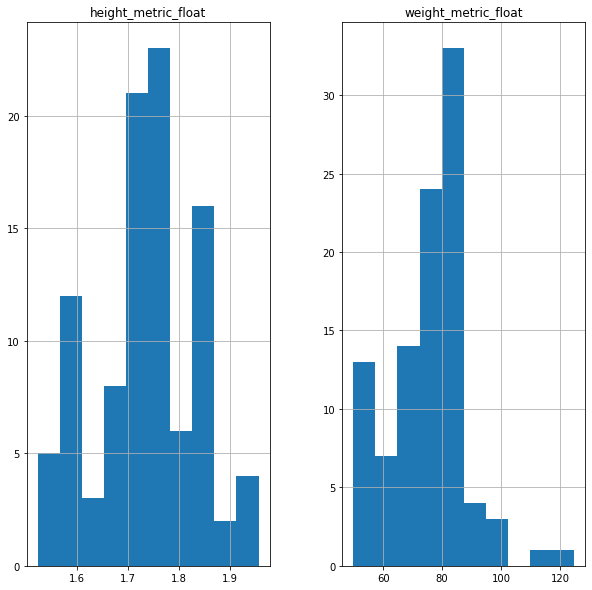

In [34]:
dset.loc[:, ["height_metric_float", "weight_metric_float"]].hist(figsize=(10, 10))

The same dataset contains a lot _tall_ people, and very few _overweight_ people.

Because we know the exact rules for true label calculation, we could contribute to the label balance-ness by generating more samples for categories `2`, `1` and `3`

I have a following strategy:
I would generate close to realistic data based on reversed formula of BMI calcuation, plus, I would need some close to realistic data to begin with, either `height` or `weight`.

I'd like to start with `height`

In [35]:
dset['height_metric_float'].describe()

count    100.000000
mean       1.736344
std        0.100213
min        1.524000
25%        1.676400
50%        1.752600
75%        1.803400
max        1.955800
Name: height_metric_float, dtype: float64

array([[<AxesSubplot:title={'center':'age_int'}>,
        <AxesSubplot:title={'center':'gender_c_int'}>],
       [<AxesSubplot:title={'center':'height_metric_float'}>,
        <AxesSubplot:title={'center':'weight_metric_float'}>],
       [<AxesSubplot:title={'center':'bmi_float'}>,
        <AxesSubplot:title={'center':'bmi_target_c_int'}>]], dtype=object)

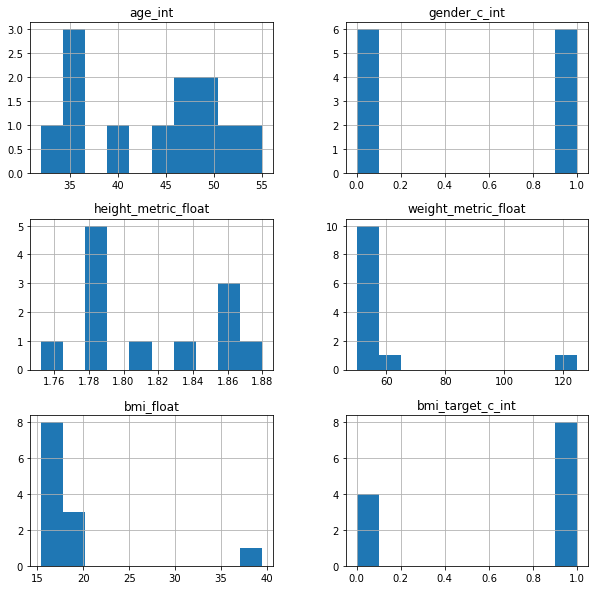

In [36]:
# this will give us the distribution of each variables contributing to the so-called "abnormal" classes

abnormal = dset.loc[dset['bmi_target_c_int'] != 3, :]
abnormal.hist(figsize=(10, 10))

Here we observed that there is no `2` in the label, meaning we need to create some people with `age` greater than 60; as well as more overweight and udnerweight people. But we __shouldn't__ create people with crazy `heights` i.e. 2+ meters

In [37]:
def generate_abnormal_data_with_target_label(num_cls_label:List[int]) -> np.ndarray:
    # num_cls_label is the numbers of each class label to be generated
    # the labels should be 1, 2 and 3
    # the return value contains 6 columns:
    # 1. age_int
    # 2. gender_c_int
    # 3. height_metric_float
    # 4. weight_metric_float
    # 5. bmi_float
    # 6. bmi_target_c_int

    assert len(num_cls_label) == 3, "number of abnormal labels should be 3"

    data_columns = ["age_int", "gender_c_int", "height_metric_float", "weight_metric_float", "bmi_float", "bmi_target_c_int"]
    res = np.empty((1, 6))
    # loop over num_cls_label to generate required number of target class data
    for ith_label, num in enumerate(num_cls_label):

        height = np.random.normal(loc=1.736344, scale=0.100213, size=num)
        gender = np.random.randint(0, 2, size=num)
        if ith_label == 0:
            age_low, age_high = 18, 39
            bmi_float_high, bmi_float_low = 17.49, 38.5
        elif ith_label == 1:
            age_low, age_high = 40, 59
            bmi_float_high, bmi_float_low = 18.49, 38.5
        elif ith_label == 2:
            age_low, age_high = 60, 100
            bmi_float_high, bmi_float_low = 18.49, 38.5
        
        bmi_float = np.random.uniform(low=0, high=bmi_float_low, size=num//2)
        
        bmi_float = np.concatenate([bmi_float, np.random.uniform(low=bmi_float_high, high=50, size=num//2)])
        
        weight = height ** 2 * bmi_float
        
        age = np.random.randint(age_low, age_high, size=num)

        data = np.hstack((
            age[np.newaxis].T, 
            gender[np.newaxis].T, 
            height[np.newaxis].T, 
            weight[np.newaxis].T, 
            bmi_float[np.newaxis].T, 
            np.array([ith_label for _ in range(num)])[np.newaxis].T
        ))

        
        res = np.vstack((res, data))

    return pd.DataFrame(res, columns=data_columns).iloc[1:, :]

            
generate_abnormal_data_with_target_label([60, 40, 80])
    

,age_int,gender_c_int,height_metric_float,weight_metric_float,bmi_float,bmi_target_c_int
1,29.0,1.0,1.668197,85.196954,30.614668,0.0
2,30.0,1.0,1.759619,32.284816,10.427042,0.0
3,29.0,1.0,1.765714,52.691133,16.900400,0.0
4,31.0,1.0,1.664757,8.371255,3.020571,0.0
5,19.0,1.0,1.923319,3.610389,0.976004,0.0
...,...,...,...,...,...,...
176,91.0,1.0,1.927692,109.186722,29.382881,2.0
177,89.0,0.0,1.596189,61.688195,24.212144,2.0
178,88.0,1.0,1.792761,151.428096,47.115277,2.0
179,88.0,1.0,1.671141,102.974791,36.872675,2.0


This looks very promising

array([[<AxesSubplot:title={'center':'age_int'}>,
        <AxesSubplot:title={'center':'gender_c_int'}>],
       [<AxesSubplot:title={'center':'height_metric_float'}>,
        <AxesSubplot:title={'center':'weight_metric_float'}>],
       [<AxesSubplot:title={'center':'bmi_float'}>,
        <AxesSubplot:title={'center':'bmi_target_c_int'}>]], dtype=object)

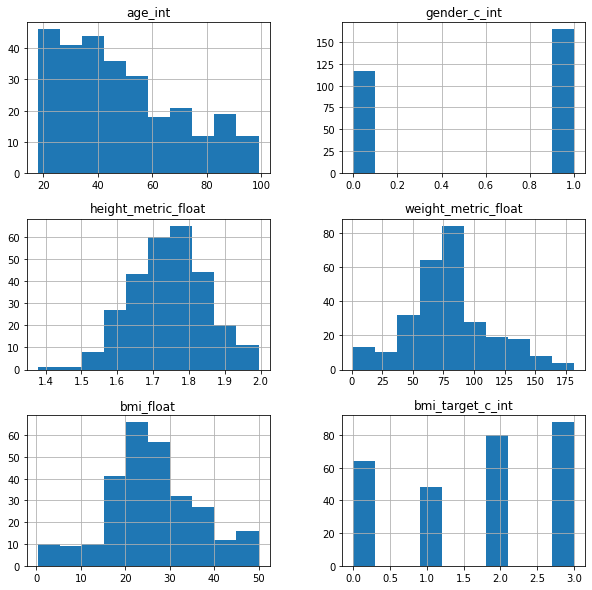

In [38]:
synthetic_dset = pd.concat([dset.iloc[:, 1:], generate_abnormal_data_with_target_label([60, 40, 80])]).sample(frac=1)
synthetic_dset.hist(figsize=(10, 10))

Now let's try some machine learning on this new dataset

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(*get_X_y(synthetic_dset), test_size=0.2, random_state=42)
print(np.unique(y_train), np.unique(y_test))

print(f"y_train value counts:\n{pd.value_counts(y_train)}")
print(f"y_test value counts:\n{pd.value_counts(y_test)}")

[0. 1. 2. 3.] [0. 1. 2. 3.]
y_train value counts:
3.0    74
2.0    65
0.0    49
1.0    36
dtype: int64
y_test value counts:
2.0    15
0.0    15
3.0    14
1.0    12
dtype: int64


In [40]:

clf_lr_synthetic = LogisticRegression(multi_class='multinomial', max_iter=1000)
clf_lr_synthetic.fit(X_train, y_train)
y_pred = clf_lr_synthetic.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.6428571428571429


What about old model's performance? (old model trained from given sample data, imbalanced)

In [41]:
print(f"baseline LR: {accuracy_score(y_test, clf_baseline.predict(X_test))}")
print(f"baseline RF: {accuracy_score(y_test, clf_rf.predict(X_test))}")

baseline LR: 0.30357142857142855
baseline RF: 0.32142857142857145


Great! This validates my assumption

## Training models

Typically for problems like these, decision trees are the king, among DTs, GBDT (gradient boosted decision trees) are best. So we will train 1 logistic regression, 1 randomforest and 1 gbdt without too much hyperparameter tuning and turn that model into service backbone.

accuracy 0.875
recall 0.8767857142857143
precision 0.8880090497737557
f1_score 0.8750868486352357


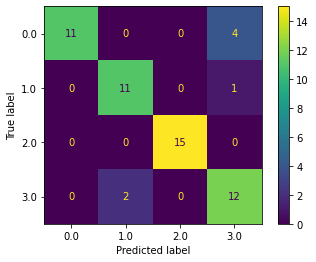

In [42]:
clf_rf_synthetic = RandomForestClassifier()
clf_rf_synthetic.fit(X_train, y_train)
y_pred = clf_rf_synthetic.predict(X_test)
print("accuracy", accuracy_score(y_test, y_pred))
print("recall", recall_score(y_test, y_pred, average="macro"))
print("precision", precision_score(y_test, y_pred, average="macro"))
print("f1_score", f1_score(y_test, y_pred, average="macro"))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()



accuracy 0.9107142857142857
recall 0.9107142857142857
precision 0.9107142857142857
f1_score 0.9107142857142857


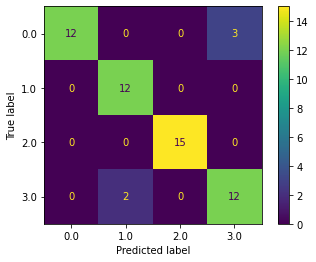

In [43]:
clf_gbdt_synthetic = GradientBoostingClassifier()
clf_gbdt_synthetic.fit(X_train, y_train)
y_pred = clf_gbdt_synthetic.predict(X_test)
print("accuracy", accuracy_score(y_test, y_pred))
print("recall", recall_score(y_test, y_pred, average="micro"))
print("precision", precision_score(y_test, y_pred, average="micro"))
print("f1_score", f1_score(y_test, y_pred, average="micro"))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()


accuracy 0.8571428571428571
recall 0.8571428571428571
precision 0.8836996336996338
f1_score 0.8582142857142857


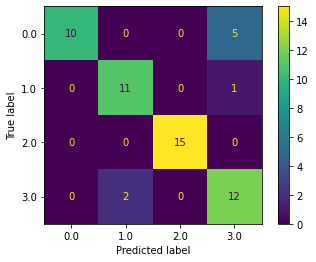

In [44]:
import lightgbm as lgb

clf_gbm_synthetic = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=2000, random_state=42, n_jobs=8)
clf_gbm_synthetic.fit(X_train, y_train)
y_pred = clf_gbm_synthetic.predict(X_test)
print("accuracy", accuracy_score(y_test, y_pred))
print("recall", recall_score(y_test, y_pred, labels=np.unique(y_test), average="weighted"))
print("precision", precision_score(y_test, y_pred, labels=np.unique(y_test), average="weighted"))
print("f1_score", f1_score(y_test, y_pred, labels=np.unique(y_test), average="weighted"))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()



`lgbm` tends to out-perform sklearn models __if__ tuned extensively, which I don't think I should aim for given that _"Done is better than perfect"_ 

## Conclude the experiment phase

With accuracy over `90%` and high `f1_score`, it's good enough for first deployment. So we need to save the model (and the synthecised dataset too)

In [45]:
from joblib import dump, load
# dump(clf_gbm_synthetic, "../model/clf_gbm_synthetic_8571.joblib")
# dump(clf_gbdt_synthetic, "../model/clf_gdbt_synthetic_9111.joblib")

# synthetic_dset.to_csv("../data/synthetic.csv", index=False)